# Universidad Politécnica Salesiana



![Universidad Politécnica Salesiana](https://github.com/vlarobbyk/fundamentos-vision-artificial-doctoradoCC/blob/main/images/Logo-UPS-30-Años.png?raw=true)

# $${\color{blue}{\small{ Visión ~por~ Computador \\ Carrera ~de~ Computación}}}$$

# UNIDAD 3.  <font color='darkred'>Guía de los Fundamentos Matemáticos del Descriptor SIFT (Scale Invariant Feature Transform)</font>

**Objetivo:** Comprender matemáticamente cómo SIFT transforma una imagen en vectores de características invariantes a rotación, traslación y escala.
**Herramienta:** PyTorch.

SIFT (Scale-Invariant Feature Transform), publicado por David Lowe en 2004, es considerado un  hito en la historia de la visión por computador. Su propósito es transformar una imagen en una colección de vectores de características locales que son invariantes a la escala (tamaño) y rotación, y parcialmente invariantes a cambios en la iluminación y el punto de vista 3D.

Gracias a su robustez matemática, SIFT es el motor detrás de muchas tecnologías que usamos hoy en día:

* **Reconocimiento de Objetos:** Identificar un objeto específico en una escena desordenada y parcialmente oculta.

* **Stitching de Imágenes (Panoramas):** Es la tecnología que permite a un celular unir múltiples fotos para crear una panorámica perfecta, encontrando puntos coincidentes entre ellas.

* **Modelado 3D y Fotogrametría:** Permite reconstruir la estructura 3D de una escena a partir de fotos 2D tomadas desde diferentes ángulos (como en Google Earth).

* **Navegación Robótica (SLAM):** Ayuda a los robots y vehículos autónomos a crear mapas de su entorno y saber dónde están ubicados.

* **Búsqueda de Imágenes:** Buscar imágenes similares en grandes bases de datos (como Google Lens).

## Las 5 Etapas del Algoritmo
Para lograr esta robustez, SIFT procesa la imagen a través de una tubería ("pipeline") secuencial de 5 pasos fundamentales. Esta guía desglosará matemáticamente cada uno de ellos:

1. **Scale-space peak selection (Selección de picos en espacio-escala):** Búsqueda preliminar de puntos de interés en diferentes tamaños usando la Pirámide Gaussiana.

2. **Keypoint Localization (Localización precisa del Keypoint):** Refinamiento matemático para eliminar puntos inestables y bordes, utilizando la Matriz Hessiana.

3. **Orientation Assignment (Asignación de orientación):** Cálculo de la dirección dominante del punto para lograr invarianza a la rotación.

4. **Keypoint descriptor (Descriptor del Keypoint):** Creación de una "huella digital" numérica (vector) basada en gradientes locales.

5. **Keypoint Matching (Coincidencia):** Comparación de vectores para encontrar correspondencias entre diferentes imágenes.



## <font color='orange'>1. Scale-space Peak Selection (Selección de Picos en Espacio-Escala)</font>

**Concepto:** En el mundo real, los objetos se ven a diferentes distancias. Un "punto" no puede ser solo un píxel; debe existir en una cierta escala (tamaño).

SIFT busca características que sean estables independientemente de si la imagen se hace grande o pequeña.

**Fundamento Matemático:** SIFT construye una "Pirámide Gaussiana". Para ello, realiza la convolución de la imagen $I(x,y)$ con filtros Gaussianos $G(x,y,\sigma)$ de diferentes amplitudes ($\sigma$).

$$L(x,y,\sigma) = G(x,y,\sigma) * I(x,y)$$

Para detectar bordes y esquinas de manera eficiente, SIFT usa la **Diferencia de Gaussianas (DoG):** resta dos imágenes borrosas consecutivas.

$$D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)$$

![Diferencia de Gaussianas](https://docs.opencv.org/4.x/sift_dog.jpg)

Ilustración 1. Diferencia de Gaussianas considerando diferentes niveles de escala de la imagen (octavas). Fuente: [Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)



* **Picos:** Se busca un píxel que sea el máximo o mínimo local comparado con sus 8 vecinos en la misma escala y sus 9+9 vecinos en las escalas adyacentes (arriba y abajo).


![Búsqueda del pixel máximo o mínimo local](https://docs.opencv.org/4.x/sift_local_extrema.jpg)

Ilustración 2. Búsqueda del pixel máximo o mínimo local. Fuente: [Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

## <font color='orange'> 2. Keypoint Localization (Localización Precisa del Keypoint) </font>

En este punto se emplea la Matriz Hessiana. Los "picos" encontrados en el paso 1 son aproximados (a nivel de píxel) y pueden estar en bordes simples (que son malos puntos de referencia). Necesitamos refinarlos.

### <font color='blue'> 2.1 Refinamiento Sub-píxel (Series de Taylor) </font>

Para encontrar la ubicación exacta del extremo (incluso entre píxeles), SIFT usa la expansión de Taylor de la función DoG ($D$):

$$D(\mathbf{x}) = D + \frac{\partial D^T}{\partial \mathbf{x}}\mathbf{x} + \frac{1}{2}\mathbf{x}^T \frac{\partial^2 D}{\partial \mathbf{x}^2} \mathbf{x}$$


Derivando e igualando a cero, obtenemos el desplazamiento exacto $\hat{\mathbf{x}}$ hacia el pico real.

Este es uno de los pasos matemáticamente más elegantes de SIFT. Es fundamental porque el mundo real es continuo, pero las imágenes digitales son discretas (píxeles).

Si solo nos quedáramos con el "píxel más brillante" detectado en el paso 1, nuestro error podría ser de hasta 0.5 píxeles. En visión por computador de alta precisión (como reconstrucción 3D), ese error es inaceptable.

#### <font color='green'> 2.1 Refinamiento Sub-píxel: La Intuición</font>

Imaginemos que estamos buscando la cima de una montaña.

* **Paso 1 (Discreto):** Nos ubicamos en varios puntos fijos (píxeles) y encontramos cuál está más alto. Digamos que estamos ubicados en el píxel $(10, 10)$.

* **Problema:** La verdadera cima de la montaña probablemente no está exactamente en el lugar donde estamos ubicados en $(10, 10)$, sino tal vez un poco a la derecha, en $(10.4, 9.8)$.

* **Solución (Series de Taylor):** Si miramos la curvatura del terreno a nuestro alrededor (usando los vecinos) y ajustamos matemáticamente una curva suave (una parábola 3D) para predecir dónde está el pico real de esa curva.

#### <font color='green'> El Desarrollo Matemático </font>

SIFT utiliza la **Expansión de Series de Taylor de segundo orden** para aproximar la función de **Diferencia de Gaussianas** $D(x, y, \sigma)$ alrededor del punto candidato.

Consideramos el vector de desplazamiento $\mathbf{x} = (x, y, \sigma)^T$ desde el punto de muestra. La expansión es:

$$D(\mathbf{x}) = D + \frac{\partial D^T}{\partial \mathbf{x}}\mathbf{x} + \frac{1}{2}\mathbf{x}^T \frac{\partial^2 D}{\partial \mathbf{x}^2} \mathbf{x}$$

Donde:

1. $D$: Es el valor de intensidad en el píxel candidato original.
2. $\frac{\partial D}{\partial \mathbf{x}}$: Es el Gradiente (primera derivada). Nos dice la pendiente en $x, y, \sigma$.
3. $\frac{\partial^2 D}{\partial \mathbf{x}^2}$: Es la Matriz Hessiana ($H$) de segundas derivadas. Nos dice la curvatura (qué tan rápido cambia la pendiente).

#### <font color='green'>Encontrando el Máximo Exacto </font>

Para encontrar la ubicación del pico verdadero (el extremo), tomamos la derivada de la ecuación anterior con respecto a $\mathbf{x}$ y la igualamos a cero (condición de máximo/mínimo en cálculo):

$$\frac{\partial D(\mathbf{x})}{\partial \mathbf{x}} \approx \nabla D + H\mathbf{x} = 0$$

Ahora, despejamos $\mathbf{x}$ para encontrar el desplazamiento óptimo ($\hat{\mathbf{x}}$):

$$\hat{\mathbf{x}} = -H^{-1} \nabla D$$


#### <font color='green'>Implementación Práctica (Diferencias Finitas) </font>

En una imagen no tenemos una función continua para derivar, solo tenemos píxeles vecinos. Por eso, calculamos las derivadas usando **Diferencias Finitas Centrales**.

Para un punto $(x, y)$ en la escala $\sigma$:

1. **El Gradiente** ($\nabla D$): Es un vector de 3 elementos. Ejemplo para $x$:

$$\frac{\partial D}{\partial x} = \frac{D(x+1, y, \sigma) - D(x-1, y, \sigma)}{2}$$

(Se hace lo mismo para $y$ y para la escala $\sigma$ usando las imágenes de capas superior e inferior).

2. **La Hessiana** ($H$):Es una matriz de $3 \times 3$.

$$H = \begin{bmatrix}
D_{xx} & D_{xy} & D_{x\sigma} \\
D_{yx} & D_{yy} & D_{y\sigma} \\
D_{\sigma x} & D_{\sigma y} & D_{\sigma\sigma}
\end{bmatrix}$$

Ejemplo para la segunda derivada en $x$ ($D_{xx}$):

$$D_{xx} = D(x+1) - 2D(x) + D(x-1)$$


Ejemplo para la derivada cruzada ($D_{xy}$):

$$D_{xy} = \frac{D(x+1, y+1) - D(x-1, y+1) - D(x+1, y-1) + D(x-1, y-1)}{4}$$


#### <font color='green'>Interpretación del Resultado ($\hat{\mathbf{x}}$) </font>


Al resolver $\hat{\mathbf{x}} = -H^{-1} \nabla D$, obtendremos un vector de 3 valores, por ejemplo: $\hat{\mathbf{x}} = (0.4, -0.2, 0.1)$.

1. **Significado:** El pico real está $0.4$ píxeles a la derecha, $0.2$ píxeles hacia arriba y en una escala $0.1$ veces mayor que la actual.

2. **Nueva Ubicación:** La ubicación final del Keypoint ya no es el entero $(10, 10)$, sino el flotante $(10.4, 9.8)$.

3. **Regla de Descarte:** Si el desplazamiento calculado en cualquier dimensión es mayor a 0.5, significa que el pico real está más cerca de otro píxel vecino. En ese caso, movemos el centro al vecino y repetimos el proceso.


#### <font color='green'>Resumen Visual</font>

* **Sin este paso:** Los keypoints "vibrarían" al mover la cámara, porque saltarían bruscamente de un píxel a otro.
* **Con este paso:** Los keypoints se deslizan suavemente entre píxeles, permitiendo una precisión sub-píxel crucial para el matching.


### <font color='blue'> 2.2 Eliminación de Bordes (La Matriz Hessiana) </font>

Un buen keypoint es una esquina (curvatura alta en $X$ e $Y$). Un mal keypoint es un borde (curvatura alta en $X$, pero plana en $Y$).

SIFT analiza la curvatura usando la **Matriz Hessiana** $H$:

$$H =
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}$$

Sean $\alpha$ la curvatura mayor (valor propio grande) y $\beta$ la curvatura menor (valor propio pequeño). Queremos que la relación $r = \alpha / \beta$ sea pequeña. Si $r$ es grande, es un borde.


Analizamos la **Traza** ($Tr(H) = \alpha + \beta$) y el **Determinante** ($Det(H) = \alpha \beta$).

#### <font color='green'>La Inecuación de Estabilidad:</font>

$$\frac{Tr(H)^2}{Det(H)} < \frac{(r+1)^2}{r}$$

**¿Por qué SIFT usa $r=10$?**

Lowe (creador de SIFT) determinó empíricamente que $r=10$ es el límite óptimo para descartar bordes inestables.Sustituyamos $r=10$ en la fórmula:

Lado derecho: $\frac{(10+1)^2}{10} = \frac{121}{10} = \mathbf{12.1}$

Por lo tanto, el algoritmo verifica para cada punto candidato:

$$\frac{(D_{xx} + D_{yy})^2}{D_{xx}D_{yy} - (D_{xy})^2} < 12.1$$

Si el valor calculado es mayor a 12.1, el punto tiene una curvatura tipo "borde" muy pronunciada y se **descarta**.


## <font color='orange'> 3. Orientation Assignment (Asignación de Orientación) </font>

**Concepto:** Para que el descriptor sea invariante a la rotación, primero calculamos la dirección dominante del keypoint y luego "giramos" todo el análisis relativo a esa dirección.

**Fundamento Matemático:** Tomamos una ventana alrededor del keypoint y calculamos magnitud $m(x,y)$ y orientación $\theta(x,y)$ para cada píxel (usando diferencias centrales, como veremos en el código más adelante).

Se crea un **Histograma de Orientación de 36 bins** (cada bin cubre $10^\circ$).

* Los picos en este histograma indican la dirección dominante del objeto.
* Si hay un pico en $90^\circ$ (Norte), el descriptor se calculará rotando las coordenadas para que el "Norte" sea el eje de referencia.


## <font color='orange'> 4. Keypoint Descriptor (Descriptor del Keypoint) </font>

Esta es la etapa donde convertimos los píxeles en un vector numérico (firma). **Estándar SIFT:** Usa una rejilla de $16 \times 16$ píxeles, dividida en 4x4 subregiones, generando un vector de 128 dimensiones. Para un ejemplo práctico se usará una versión simplificada ($7 \times 7$) para entender la matemática.

**Fundamento Matemático:**

1. Calcular gradientes ($G_x, G_y$).
2. Ponderar con una ventana Gaussiana (dar peso al centro).
3. Interpolar trilinealmente en un histograma de orientaciones (8 bins).


**Ejercicio Práctico en PyTorch (Paso a Paso)**

Procedemos a importar las librerías correspondientes para realizar el proceso:

DESCRIPTOR FINAL (Vector de 8 dimensiones):
tensor([0.5774, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


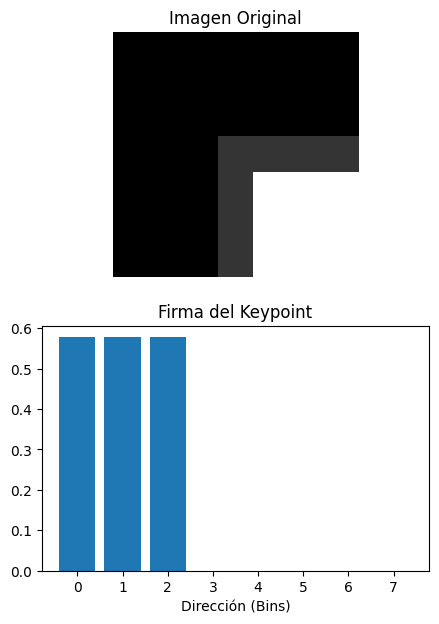

In [ ]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as pp

# --- PASO 1: DEFINICIÓN DEL PARCHE (7x7) ---
# Simulamos un Keypoint detectado en la etapa 2.
# Patrón: Una esquina brillante en la esquina inferior derecha.
data = [
    [10, 10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10, 10],
    [10, 10, 10, 50, 50, 50, 50],
    [10, 10, 10, 50, 200, 200, 200],
    [10, 10, 10, 50, 200, 200, 200],
    [10, 10, 10, 50, 200, 200, 200]
]
img = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# --- PASO 2: CÁLCULO DE GRADIENTES (Diferencias Centrales) ---
# Formula: Gx = I(x+1) - I(x-1)
kx = torch.tensor([[-1., 0., 1.]], dtype=torch.float32).view(1, 1, 1, 3)
ky = torch.tensor([[-1.], [0.], [1.]], dtype=torch.float32).view(1, 1, 3, 1)

Gx = F.conv2d(img, kx)
Gy = F.conv2d(img, ky)

# Recorte: Al usar kernel de 3, perdemos 1 pixel por lado. 7x7 -> 5x5
Gx = Gx[:, :, 1:-1, :]
Gy = Gy[:, :, :, 1:-1]

# --- PASO 3: MAGNITUD Y ORIENTACIÓN ---
# Math: m = sqrt(gx^2 + gy^2), theta = atan2(gy, gx)
magnitude = torch.sqrt(Gx**2 + Gy**2)
theta_rad = torch.atan2(Gy, Gx)
theta_deg = (torch.rad2deg(theta_rad) + 360) % 360 # Normalizar 0-360

# --- PASO 4: PONDERACIÓN GAUSSIANA ---
# Math: W = m * exp(-dist^2 / 2sigma^2)
y_grid, x_grid = torch.meshgrid(torch.arange(5), torch.arange(5), indexing='ij')
center = 2.0
sigma = 1.5 # Sigma estándar relativo al parche
gaussian_weight = torch.exp(-((x_grid - center)**2 + (y_grid - center)**2) / (2 * sigma**2))

weighted_magnitude = magnitude.squeeze() * gaussian_weight

# --- PASO 5: HISTOGRAMA DE ORIENTACIÓN (8 Bins) ---
# Cada bin cubre 45 grados.
bin_indices = torch.floor(theta_deg.squeeze() / 45.0).long()
bin_indices = torch.clamp(bin_indices, 0, 7)

histogram = torch.zeros(8)
flat_bins = bin_indices.view(-1)
flat_mags = weighted_magnitude.view(-1)

for i in range(flat_bins.shape[0]):
    histogram[flat_bins[i]] += flat_mags[i]

# --- PASO 6: NORMALIZACIÓN DEL VECTOR ---
# Invarianza a iluminación (Contraste)
descriptor = histogram / (torch.norm(histogram, p=2) + 1e-7)
# Recorte de saturación (Standard SIFT clip at 0.2)
descriptor = torch.clamp(descriptor, max=0.2)
# Re-normalización
descriptor = descriptor / (torch.norm(descriptor, p=2) + 1e-7)

print("DESCRIPTOR FINAL (Vector de 8 dimensiones):")
print(descriptor)

figure, axes = pp.subplots(nrows = 2, ncols = 1)
figure.set_size_inches(5,7)

axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title("Imagen Original")
axes[0].axis('off')

axes[1].bar(range(8), descriptor.numpy())
axes[1].set_title("Firma del Keypoint")
axes[1].set_xlabel("Dirección (Bins)")

pp.show()

## <font color='orange'> 5. Keypoint Matching (Coincidencia de Puntos) </font>


Una vez que tenemos los descriptores de dos imágenes (Imagen $A$ e Imagen $B$), ¿cómo sabemos cuáles coinciden?

**Fundamento Matemático:**
1. **Distancia Euclídea:** Se calcula la distancia $d(D_A, D_B) = ||D_A - D_B||_2$ entre un punto de $A$ y todos los puntos de $B$.

2. **Lowe's Ratio Test (Test de Razón):** No basta con encontrar el vecino más cercano. En imágenes repetitivas, el vecino más cercano puede ser un falso positivo. Lowe propuso comparar la distancia del vecino más cercano ($d_1$) con la del segundo vecino más cercano ($d_2$).

$$Ratio = \frac{d_1}{d_2}$$

Si $Ratio < 0.8$, aceptamos la coincidencia.
* **Lógica:** Si $d_1 \approx d_2$, significa que el punto se parece a muchos otros (es ambiguo). Queremos que el punto sea único ($d_1 \ll d_2$).

## <font color='orange'> Ejemplo de cálculo de la Matriz Hessiana </font>

Para el cálculo de la matriz Hessiana para nuestro ejemplo vamos a trabajar con la coordenada $C(x = 3, y = 4)$, donde $x$ representa la columna e $y$ la fila:

**Matriz (recorte alrededor de la coordenada dada):**

$$M = \begin{bmatrix}
10 & 50 & 50 \\
10 & 50 & 200 \\
10 & 50 & 200 \\
\end{bmatrix}$$


**Fórmulas de Diferencias Finitas (Segundas Derivadas):**

Para la Hessiana $H = \begin{bmatrix} D_{xx} & D_{xy} \\ D_{xy} & D_{yy} \end{bmatrix}$, usamos estas aproximaciones:

1. $D_{xx}$ (Curvatura Horizontal): $I(x+1, y) - 2I(x, y) + I(x-1, y)$
2. $D_{yy}$ (Curvatura Vertical): $I(x, y+1) - 2I(x, y) + I(x, y-1)$
3. $D_{xy}$ (Curvatura Diagonal): $\frac{I(x+1, y+1) - I(x-1, y+1) - I(x+1, y-1) + I(x-1, y-1)}{4}$


**Cálculo Manual**

**A. Calcular $D_{xx}$ (Aceleración en el eje X)** Miramos izquierda y derecha del 50.

* Derecha ($x+1$): 200
* Centro ($x$): 50
* Izquierda ($x-1$): 10

$$D_{xx} = 200 - 2(50) + 10 = 200 - 100 + 10 = \mathbf{110}$$

(Interpretación: Hay un cambio muy brusco de intensidad horizontalmente).


**B. Calcular $D_{yy}$ (Aceleración en el eje Y)** Miramos arriba y abajo del 50.
* Abajo ($y+1$): 50
* Centro ($y$): 50
* Arriba ($y-1$): 50

$$D_{yy} = 50 - 2(50) + 50 = 0$$

(Interpretación: No hay curvatura vertical, es una línea recta en ese eje).

**C. Calcular $D_{xy}$ (Torsión Diagonal)** Miramos las 4 esquinas diagonales.

* Abajo-Derecha ($x+1, y+1$): 200
* Arriba-Izquierda ($x-1, y-1$): 10
* Arriba-Derecha ($x+1, y-1$): 50
* Abajo-Izquierda ($x-1, y+1$): 10

$$D_{xy} = \frac{(200 + 10) - (50 + 10)}{4} = \frac{210 - 60}{4} = \frac{150}{4} = \mathbf{37.5}$$




**La Matriz Resultante**

Para este píxel específico $(3,4)$, la Matriz Hessiana es:


$$H = \begin{bmatrix}
110 & 37.5 \\
37.5 & 0
\end{bmatrix}$$

**¿Qué haría SIFT con este punto? (Evaluación)**

Ahora aplicamos la prueba de curvatura principal (Trace y Determinante) para ver si es un buen keypoint.

* **Traza** ($Tr$): $110 + 0 = 110$
* **Determinante** ($Det$): $(110 \cdot 0) - (37.5)^2 = -1406.25$

**Conclusión:** El determinante es negativo. Matemáticamente, esto indica un **Punto de Silla (Saddle Point)**. En el contexto de SIFT y detección de esquinas, esto sugiere una estructura compleja o un borde muy fuerte en una sola dirección.

Si aplicamos la fórmula de SIFT ($r=10$):

$$\frac{Tr^2}{Det} = \frac{110^2}{-1406.25} \approx -8.6$$

Dado que el determinante es negativo, este punto específico no es un máximo/mínimo local convexo estándar (como la cima de una montaña), sino un punto de transición en el borde.3 SIFT descartaría este punto específico en la etapa de localización o lo consideraría inestable, buscando en su lugar un punto donde el determinante sea positivo (curvatura alta en ambas direcciones, como un píxel más adentro de la esquina blanca).

Si el resultado hubiera sido positivo 8.6, el punto sería **aceptado como un Keypoint válido** y pasaría a la siguiente etapa del algoritmo.


**La Condición de Aceptación (El Umbral)**

El algoritmo SIFT utiliza un parámetro de curvatura $r=10$ (ratio entre la curvatura principal mayor y menor). La fórmula de umbral es:
$$\text{Umbral Máximo} = \frac{(r+1)^2}{r} = \frac{(10+1)^2}{10} = \frac{121}{10} = \mathbf{12.1}$$

La regla de decisión es:

* Si $\frac{Tr^2}{Det} < 12.1$, el punto **SE ACEPTA**.
* Si $\frac{Tr^2}{Det} > 12.1$, el punto **SE DESCARTA (es un borde).**

**Evaluando tu caso (8.6)**
$$8.6 < 12.1$$

Como $8.6$ está por debajo del límite, el algoritmo determina que la relación entre las curvaturas (la forma del pico) es lo suficientemente "redonda" o equilibrada.

**Significado Físico**

* **Valor Negativo (ej. -8.6):** Es un **Punto de Silla.** Sube por un lado y baja por el otro. Se descarta.
* **Valor Alto Positivo (ej. 15.0):** Es un Borde. La curvatura es muy fuerte en una dirección y plana en la otra (como el filo de una mesa). Se descarta porque los bordes no son puntos únicos (se parecen a lo largo de toda la línea).
* **Valor Bajo Positivo (ej. 8.6):** Es una Esquina o Blob. Significa que hay curvatura significativa en ambas direcciones (X e Y). Aunque una dirección pueda ser más curva que la otra, la diferencia no es extrema. Es un punto estable y único, ideal para el matching.

**Resumen:** Con un valor de 8.6, SIFT dice: *"Este es un buen punto, es una esquina sólida, vamos a calcular su descriptor"*.

# UNIDAD 3.  <font color='darkred'>SURF (Speeded-Up Robust Features)</font>

Este algoritmo fue diseñado específicamente como una versión más rápida y computacionalmente eficiente de SIFT.

Mientras que SIFT prioriza la precisión matemática exhaustiva (haciéndolo lento), SURF prioriza la velocidad utilizando aproximaciones inteligentes, lo que permite su uso en aplicaciones casi en tiempo real.

Detalle técnico de por qué SURF es más rápido:

**1. Detección del Keypoint (La gran diferencia)**
Esta es la razón principal de la velocidad de SURF.

* **SIFT (Lento):** Utiliza la **Diferencia de Gaussianas (DoG)**. Para detectar características en diferentes escalas, SIFT tiene que redimensionar la imagen progresivamente (Pirámide de Imágenes) y realizar costosas operaciones de convolución Gaussiana en cada paso.

* **SURF (Rápido):** Utiliza una aproximación de la **Matriz Hessiana** mediante **Filtros de Caja (Box Filters)** e **Imágenes Integrales**.
  * **Imágenes Integrales:** Permiten calcular la suma de píxeles dentro de cualquier área rectangular en tiempo constante $O(1)$, sin importar el tamaño del filtro.
  * En lugar de reducir el tamaño de la imagen (como SIFT), SURF simplemente aumenta el tamaño del filtro matemático, lo cual es instantáneo gracias a la imagen integral.

* **2. El Descriptor (Matemática simplificada)**

Una vez encontrado el punto, ¿cómo se describe?

* **SIFT:** Calcula el gradiente exacto en cada píxel vecino y crea un histograma de 8 bins. El vector resultante tiene **128 dimensiones**.

* **SURF:** Utiliza respuestas de **Wavelets de Haar** (sumas y restas simples de bloques de píxeles) en las direcciones X e Y. El vector estándar tiene 64 dimensiones.
  * Al tener menos dimensiones (64 vs 128), el proceso de Matching (comparar puntos entre imágenes) es mucho más rápido.



### <font color='green'>Material Bibliográfico y Web de soporte</font>

# Bibliografía
[1] Krishna, R. (2023). *Canny Edge Detection Algorithm From Scratch*. Medium. Disponible en: [Medium](https://medium.com/@rohit-krishna/coding-canny-edge-detection-algorithm-from-scratch-in-python-232e1fdceac7).

[2] Sahir, S. (2019). *Canny Edge Detection Step by Step in Python — Computer Vision*. Towards Data Science. Disponible en: [Medium](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).